In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
import umap

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 16

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

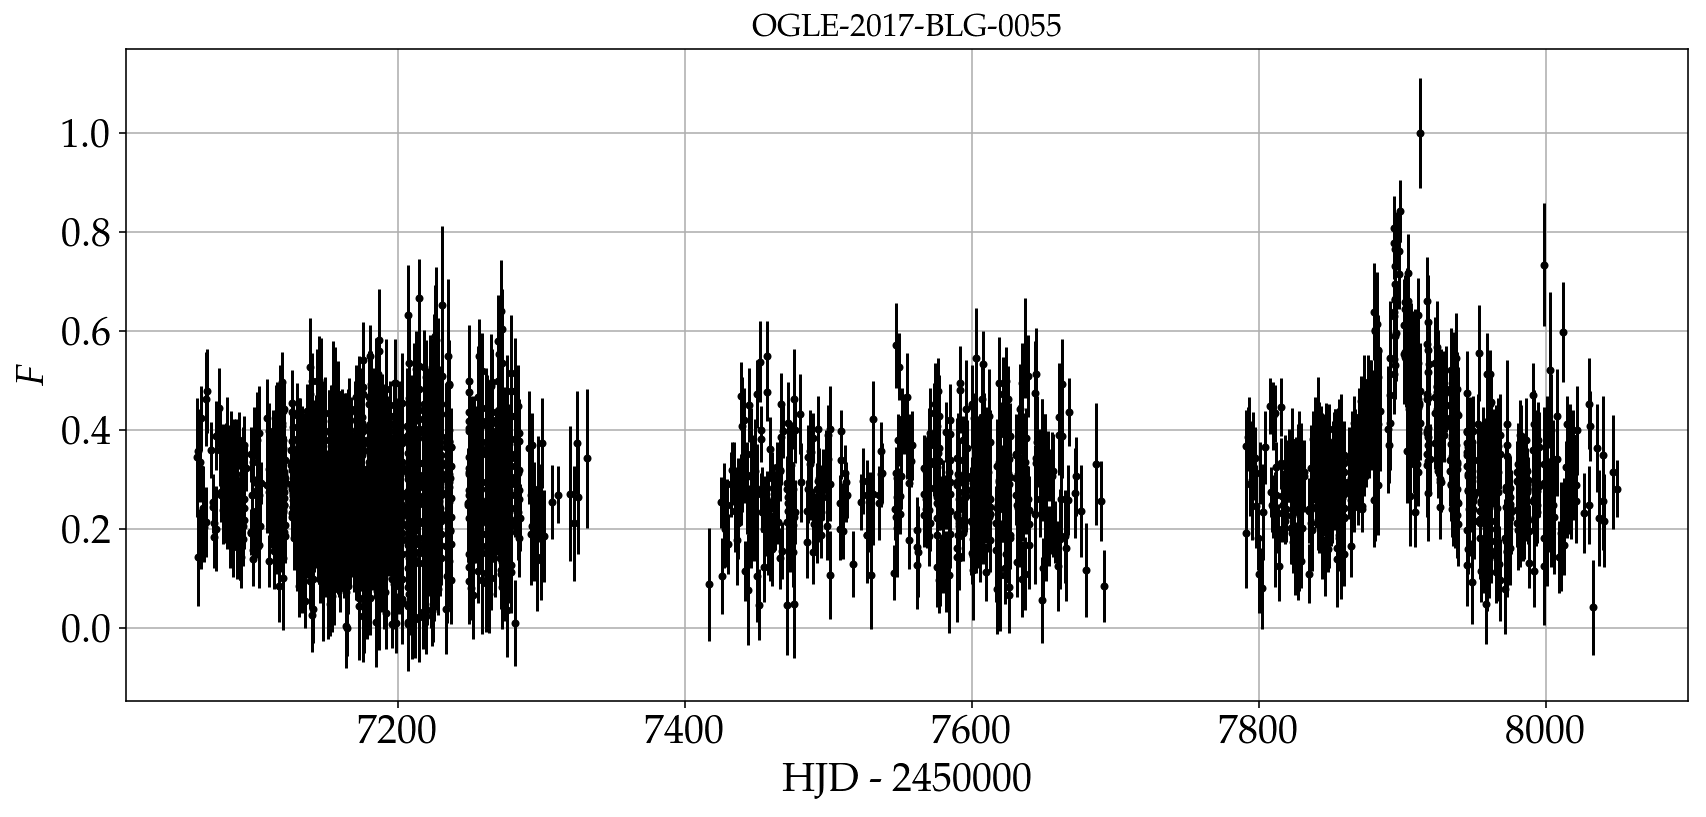

In [33]:
event = '2017/blg-0839' # '2017/0717'

data = pd.read_csv('../microlensing_data/OGLE/' + event + '/phot.dat', 
                   names=['HJD', 'I_flux', 'I_flux_err', 'seeing_est', 'sky_level'],
                   delim_whitespace=True)

mag_to_flux = lambda m: 10**(-m/2.5)
magerr_to_fluxerr = lambda m, sigm: sigm*mag_to_flux(m)

data['HJD'] -= 2450000
data['I_flux_err'] = magerr_to_fluxerr(data['I_flux'].values, data['I_flux_err'].values)
data['I_flux'] = mag_to_flux(data['I_flux'].values)

# Normalize flux units
t = data['HJD']
F = (data['I_flux'] - data['I_flux'].min())/(data['I_flux'].max() - data['I_flux'].min())
sigF = data['I_flux_err']/(data['I_flux'].max() - data['I_flux'].min())

def plot_data(ax, t, F, sigF, col):
    ax.errorbar(t, F, sigF, fmt='.', color=col, label='Data')
    ax.grid(True)
    ax.set_xlabel('HJD - 2450000')
    ax.set_ylabel('$F$')
    ax.set_title('OGLE-2017-BLG-0055');

fig, ax = plt.subplots(figsize=(14,6))
plot_data(ax,data['HJD'].values, F, sigF, 'black')

In [34]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.01,
                      metric='correlation').fit_transform(sigF.values.reshape(-1,1))

/home/fran/anaconda3/lib/python3.6/site-packages/umap/umap_.py:918: RuntimeWarning: invalid value encountered in less
  graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0


In [35]:
embedding.shape

(3342, 2)

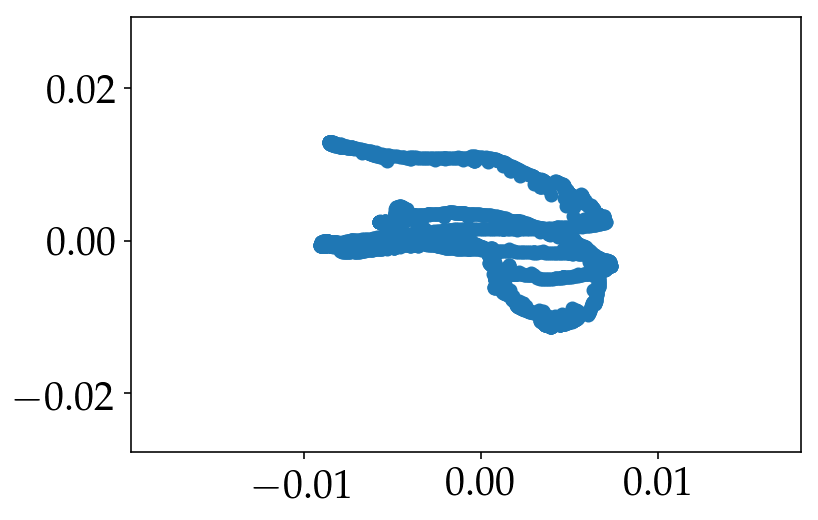

In [36]:
plt.scatter(embedding[:, 0], embedding[:, 1])

In [43]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=20).fit(data)
outlier_prob = clusterer.outlier_scores_

mask_outliers = outlier_prob > 0.8
mask_non_outliers = outlier_prob < 0.8

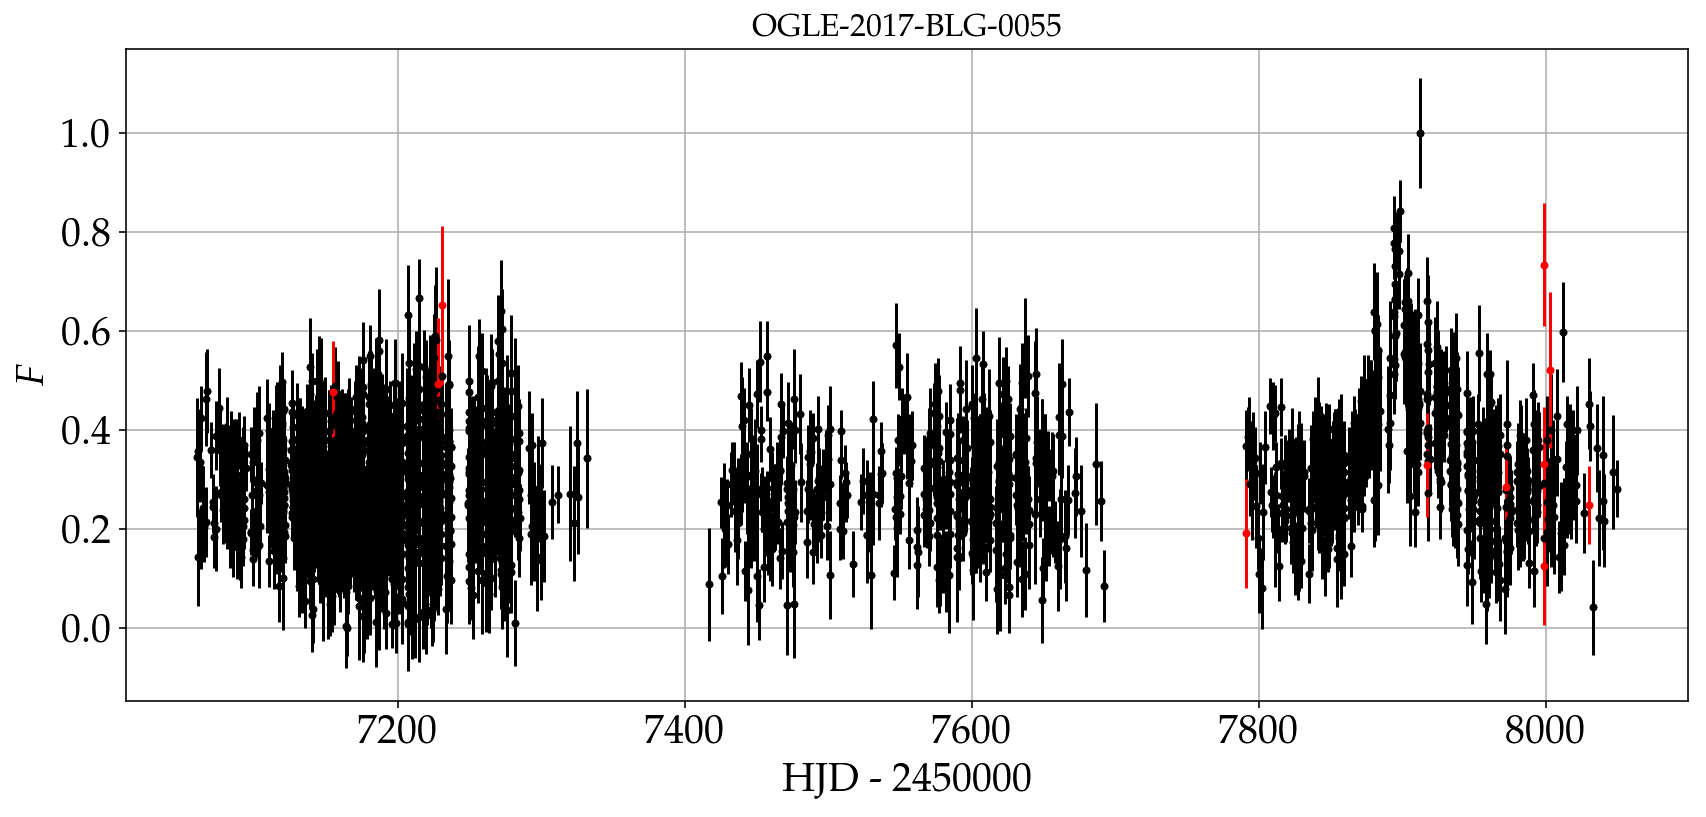

In [44]:
fig, ax = plt.subplots(figsize=(14,6))

plot_data(ax, t[mask_non_outliers], F[mask_non_outliers], sigF[mask_non_outliers], 'black')
plot_data(ax, t[mask_outliers], F[mask_outliers], sigF[mask_outliers], 'red')